# SetFit for the classification of obligations and rights
In this workbook we will reflect on how to find hyperparameters for sentence classification and result evaluation in order to solve the task of classifying legal clauses as obligation and right.

# Setup

We need to install a series of dependencies based on the libraries we are going to use `setfit` and `optuna`. In addition, we import everything we need. Last, the connection to Hugging Face is made to load the trained model.

In [1]:
## SetFit final version
!python -m pip install git+https://github.com/huggingface/setfit.git
!pip install setfit[optuna] matplotlib
!pip install umap-learn
!pip install bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4


In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer, sample_dataset
from huggingface_hub import notebook_login
from umap import UMAP
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from typing import Dict
from optuna.visualization.matplotlib import plot_param_importances
from transformers import AutoTokenizer, AutoModel
from bertviz import model_view
from bertviz import head_view

In [27]:
notebook_login()

# Load Dataset

We download our dataset, consisting of training, validation and test data.

In [3]:
dataset_id = "marmolpen3/slas-obligations-rights-sentences"
dataset = load_dataset(dataset_id)
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# Hyperparameter search

For a hyperparameter lookup we need several changes to the normal training setup:

Instead of a model, we pass a model_init function, which can optionally use the hyperparameter dictionary.
We set up a function that defines the parameters for which we are interested in optimizing.

In [5]:
model_id = "sentence-transformers/paraphrase-MiniLM-L3-v2"

In [6]:
def model_init(params):
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "lbfgs")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained(model_id, **params)

In [7]:
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 5),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        #"seed": trial.suggest_int("seed", 1, 40), default 42
        "num_iterations": trial.suggest_categorical("num_iterations", [5, 10, 20]),
    }

In [ ]:
trainer = SetFitTrainer(
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    model_init=model_init,
    loss_class=CosineSimilarityLoss,
    column_mapping={"text": "text", "label": "label"},
)

In [9]:
best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=20)

[I 2023-08-18 08:24:10,356] A new study created in memory with name: no-name-403dbbb8-9225-4a1a-9891-957715284a95
Trial: {'learning_rate': 0.0001047041524285993, 'num_epochs': 2, 'batch_size': 8, 'num_iterations': 5}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 3000
  Num epochs = 2
  Total optimization steps = 750
  Total train batch size = 8


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


[I 2023-08-18 08:24:39,425] Trial 0 finished with value: 0.73 and parameters: {'learning_rate': 0.0001047041524285993, 'num_epochs': 2, 'batch_size': 8, 'num_iterations': 5}. Best is trial 0 with value: 0.73.
Trial: {'learning_rate': 5.391868469911149e-05, 'num_epochs': 3, 'batch_size': 16, 'num_iterations': 10}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/10 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 6000
  Num epochs = 3
  Total optimization steps = 1125
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:25:30,265] Trial 1 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 5.391868469911149e-05, 'num_epochs': 3, 'batch_size': 16, 'num_iterations': 10}. Best is trial 1 with value: 0.7433333333333333.
Trial: {'learning_rate': 6.128289442526115e-05, 'num_epochs': 3, 'batch_size': 8, 'num_iterations': 10}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/10 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 6000
  Num epochs = 3
  Total optimization steps = 2250
  Total train batch size = 8


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:26:43,034] Trial 2 finished with value: 0.73 and parameters: {'learning_rate': 6.128289442526115e-05, 'num_epochs': 3, 'batch_size': 8, 'num_iterations': 10}. Best is trial 1 with value: 0.7433333333333333.
Trial: {'learning_rate': 0.00024090931116619837, 'num_epochs': 1, 'batch_size': 32, 'num_iterations': 10}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/10 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 6000
  Num epochs = 1
  Total optimization steps = 188
  Total train batch size = 32


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/188 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:27:01,129] Trial 3 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.00024090931116619837, 'num_epochs': 1, 'batch_size': 32, 'num_iterations': 10}. Best is trial 1 with value: 0.7433333333333333.
Trial: {'learning_rate': 0.00017831293548820296, 'num_epochs': 1, 'batch_size': 32, 'num_iterations': 5}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 3000
  Num epochs = 1
  Total optimization steps = 94
  Total train batch size = 32


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/94 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:27:11,375] Trial 4 finished with value: 0.7233333333333334 and parameters: {'learning_rate': 0.00017831293548820296, 'num_epochs': 1, 'batch_size': 32, 'num_iterations': 5}. Best is trial 1 with value: 0.7433333333333333.
Trial: {'learning_rate': 1.3875604831144545e-05, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20}
model_head.pkl not found on HuggingFace Hub, initialising classifica

Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 1
  Total optimization steps = 1500
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:28:01,404] Trial 5 finished with value: 0.6633333333333333 and parameters: {'learning_rate': 1.3875604831144545e-05, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20}. Best is trial 1 with value: 0.7433333333333333.
Trial: {'learning_rate': 0.0003511829287287745, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 1
  Total optimization steps = 1500
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:28:51,676] Trial 6 finished with value: 0.69 and parameters: {'learning_rate': 0.0003511829287287745, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20}. Best is trial 1 with value: 0.7433333333333333.
Trial: {'learning_rate': 0.00016010171956755138, 'num_epochs': 4, 'batch_size': 8, 'num_iterations': 10}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/10 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 6000
  Num epochs = 4
  Total optimization steps = 3000
  Total train batch size = 8


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:30:28,196] Trial 7 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.00016010171956755138, 'num_epochs': 4, 'batch_size': 8, 'num_iterations': 10}. Best is trial 1 with value: 0.7433333333333333.
Trial: {'learning_rate': 0.0004042328943701011, 'num_epochs': 5, 'batch_size': 8, 'num_iterations': 20}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 5
  Total optimization steps = 7500
  Total train batch size = 8


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:34:28,845] Trial 8 finished with value: 0.6766666666666666 and parameters: {'learning_rate': 0.0004042328943701011, 'num_epochs': 5, 'batch_size': 8, 'num_iterations': 20}. Best is trial 1 with value: 0.7433333333333333.
Trial: {'learning_rate': 5.528228312436752e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 2
  Total optimization steps = 1500
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:35:39,452] Trial 9 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 5.528228312436752e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20}. Best is trial 9 with value: 0.7566666666666667.
Trial: {'learning_rate': 0.000904589727529115, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 2
  Total optimization steps = 1500
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:36:49,260] Trial 10 finished with value: 0.7066666666666667 and parameters: {'learning_rate': 0.000904589727529115, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20}. Best is trial 9 with value: 0.7566666666666667.
Trial: {'learning_rate': 5.031155556140907e-05, 'num_epochs': 3, 'batch_size': 16, 'num_iterations': 10}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/10 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 6000
  Num epochs = 3
  Total optimization steps = 1125
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:37:45,675] Trial 11 finished with value: 0.73 and parameters: {'learning_rate': 5.031155556140907e-05, 'num_epochs': 3, 'batch_size': 16, 'num_iterations': 10}. Best is trial 9 with value: 0.7566666666666667.
Trial: {'learning_rate': 3.3868898615929255e-05, 'num_epochs': 4, 'batch_size': 16, 'num_iterations': 20}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 4
  Total optimization steps = 3000
  Total train batch size = 16


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:40:05,424] Trial 12 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 3.3868898615929255e-05, 'num_epochs': 4, 'batch_size': 16, 'num_iterations': 20}. Best is trial 9 with value: 0.7566666666666667.
Trial: {'learning_rate': 2.513292623791251e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 10}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/10 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 6000
  Num epochs = 2
  Total optimization steps = 750
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:40:42,514] Trial 13 finished with value: 0.6866666666666666 and parameters: {'learning_rate': 2.513292623791251e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 10}. Best is trial 9 with value: 0.7566666666666667.
Trial: {'learning_rate': 8.17744520964343e-05, 'num_epochs': 4, 'batch_size': 16, 'num_iterations': 5}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 3000
  Num epochs = 4
  Total optimization steps = 752
  Total train batch size = 16


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/188 [00:00<?, ?it/s]

Iteration:   0%|          | 0/188 [00:00<?, ?it/s]

Iteration:   0%|          | 0/188 [00:00<?, ?it/s]

Iteration:   0%|          | 0/188 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:41:19,971] Trial 14 finished with value: 0.74 and parameters: {'learning_rate': 8.17744520964343e-05, 'num_epochs': 4, 'batch_size': 16, 'num_iterations': 5}. Best is trial 9 with value: 0.7566666666666667.
Trial: {'learning_rate': 3.520142628622953e-05, 'num_epochs': 3, 'batch_size': 16, 'num_iterations': 20}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 3
  Total optimization steps = 2250
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:43:06,301] Trial 15 finished with value: 0.74 and parameters: {'learning_rate': 3.520142628622953e-05, 'num_epochs': 3, 'batch_size': 16, 'num_iterations': 20}. Best is trial 9 with value: 0.7566666666666667.
Trial: {'learning_rate': 1.1924914882756999e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 10}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/10 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 6000
  Num epochs = 2
  Total optimization steps = 750
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:43:43,479] Trial 16 finished with value: 0.6733333333333333 and parameters: {'learning_rate': 1.1924914882756999e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 10}. Best is trial 9 with value: 0.7566666666666667.
Trial: {'learning_rate': 9.870833357897665e-05, 'num_epochs': 5, 'batch_size': 32, 'num_iterations': 20}
model_head.pkl not found on HuggingFace Hub, initialising classifi

Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 5
  Total optimization steps = 1875
  Total train batch size = 32


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:46:33,566] Trial 17 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 9.870833357897665e-05, 'num_epochs': 5, 'batch_size': 32, 'num_iterations': 20}. Best is trial 9 with value: 0.7566666666666667.
Trial: {'learning_rate': 1.963103379903737e-05, 'num_epochs': 3, 'batch_size': 16, 'num_iterations': 10}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/10 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 6000
  Num epochs = 3
  Total optimization steps = 1125
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Iteration:   0%|          | 0/375 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:47:31,149] Trial 18 finished with value: 0.7066666666666667 and parameters: {'learning_rate': 1.963103379903737e-05, 'num_epochs': 3, 'batch_size': 16, 'num_iterations': 10}. Best is trial 9 with value: 0.7566666666666667.
Trial: {'learning_rate': 4.914966168990191e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 5}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 3000
  Num epochs = 2
  Total optimization steps = 376
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/188 [00:00<?, ?it/s]

Iteration:   0%|          | 0/188 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-18 08:47:50,189] Trial 19 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 4.914966168990191e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 5}. Best is trial 9 with value: 0.7566666666666667.


In [10]:
best_run

BestRun(run_id='9', objective=0.7566666666666667, hyperparameters={'learning_rate': 5.528228312436752e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20}, backend=<optuna.study.study.Study object at 0x7bd5c2bc3190>)

In [11]:
best_run.hyperparameters

{'learning_rate': 5.528228312436752e-05,
 'num_epochs': 2,
 'batch_size': 16,
 'num_iterations': 20}

<ipython-input-12-258fb16b29a9>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(best_run.backend);


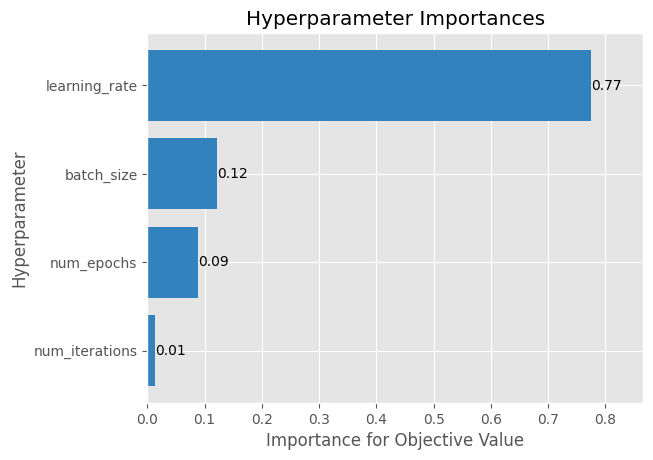

In [12]:
plot_param_importances(best_run.backend);

# Fine-tuning and upload the model to the hub

Once the most appropriate parameters for solving the required task have been verified, we apply these values to train the model. We evaluate the values of the goodness-of-fit measures at each stage of training. Finally, the model is uploaded to the Hugging face repository to make it accessible.

In [6]:
def compute_metrics(y_pred, y_test) -> Dict[str, float]:
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1_score_macro = metrics.f1_score(y_test, y_pred, average='macro')
    precision_macro = metrics.precision_score(y_test, y_pred, average="macro")
    recall_macro = metrics.recall_score(y_test, y_pred, average="macro")
    precision_micro = metrics.precision_score(y_test, y_pred, average="micro")
    recall_micro = metrics.recall_score(y_test, y_pred, average="micro")
    #f1_metric = evaluate.load("f1")
    #recall_metric = evaluate.load("recall", average="macro")
    #precision_metric = evaluate.load("precision", average="macro")

    #f1 = f1_metric.compute(references=y_test, predictions=y_pred, average="macro")
    #recall_2 = recall_metric.compute(references=y_test, predictions=y_pred, average="macro")
    #precision_2 = precision_metric.compute(references=y_test, predictions=y_pred, average="macro")

    results = [accuracy, f1_score_macro, precision_macro, recall_macro, precision_micro, recall_micro]
    return results

def get_list_metrics_values(dict):
  result = []
  for key, value in dict.items():
    res = [int(key)]
    res.extend(value)
    result.append(res)
  return result

In [76]:
model = model_init({})
num_epochs = best_run.hyperparameters['num_epochs']

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric=compute_metrics,
    num_iterations=best_run.hyperparameters['num_iterations'],
    learning_rate=best_run.hyperparameters['learning_rate'],
    batch_size=best_run.hyperparameters['batch_size'],
    column_mapping={"text": "text", "label": "label"},
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [77]:
train_metrics, eval_metrics, train_embeddings, eval_embeddings = {}, {}, {}, {}

for epoch in range(num_epochs):
    trainer.train()
    train_metrics[epoch] = trainer.evaluate(train_dataset)
    eval_metrics[epoch] = trainer.evaluate()
    train_embeddings[epoch] = model.model_body.encode(train_dataset["text"])
    eval_embeddings[epoch] = model.model_body.encode(eval_dataset["text"])

Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 1
  Total optimization steps = 750
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 1
  Total optimization steps = 750
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to evaluation dataset
***** Running evaluation *****


Metrics results.

In [78]:
print("Train results")
v_train = get_list_metrics_values(train_metrics)
df_train = pd.DataFrame(v_train, columns=['Epoch', 'Accuracy', 'F1-macro', 'Precision-macro', 'Recall-macro', 'Precision-micro', 'Recall-micro'])
df_train

Train results


Epoch  Accuracy  F1-macro  Precision-macro  Recall-macro  Precision-micro  \
0      0      0.99  0.990017         0.990066          0.99             0.99   
1      1      0.99  0.990017         0.990066          0.99             0.99   

   Recall-micro  
0          0.99  
1          0.99

In [79]:
print("Evaluation results")
v_eval = get_list_metrics_values(eval_metrics)
df_eval = pd.DataFrame(v_eval, columns=['Epoch', 'Accuracy', 'F1-macro', 'Precision-macro', 'Recall-macro', 'Precision-micro', 'Recall-micro'])
df_eval

Evaluation results


Epoch  Accuracy  F1-macro  Precision-macro  Recall-macro  Precision-micro  \
0      0      0.71  0.706596         0.719057          0.71             0.71   
1      1      0.73  0.729182         0.730144          0.73             0.73   

   Recall-micro  
0          0.71  
1          0.73

Upload to the Hugging face repository the new model specifically trained to detect obligations and rights in agreement sentences.

In [4]:
finetuning_model_id = "marmolpen3/paraphrase-MiniLM-L3-v2-sla-obligations-rights"

In [81]:
trainer.push_to_hub(finetuning_model_id)

'https://huggingface.co/marmolpen3/paraphrase-MiniLM-L3-v2-sla-obligations-rights/tree/main/'

# Analysis of the results
We observe the evolution in the training of the model through the graphical representation of the grouping of the embeddings according to their proximity. As well as the analysis of the confusion matrix for each of the available categories.

In [5]:
def print_3d_embeddings_per_epoch(embeddings, labels, title="Embeddings representation in last epoch"):
  X_scaled = MinMaxScaler().fit_transform(embeddings)
  umap_3d_components =  UMAP(n_components=3, metric="cosine").fit(X_scaled).embedding_

  result = pd.DataFrame(umap_3d_components, columns=['x', 'y', 'z'])
  result['labels'] = labels


  fig = px.scatter_3d(
    result, x='x', y='y', z='z', color=labels,
    size=[1]*len(embeddings), size_max=4, title=title
    )

  fig.update_traces(mode="markers", selector=dict(type='scatter3d'))
  fig.show()

def print_2d_embeddings_per_epoch(embeddings, labels, title="Embeddings representation in last epoch"):
  X_scaled = MinMaxScaler().fit_transform(embeddings)
  umap_2d_components = UMAP(n_components=2, metric="cosine").fit(X_scaled).embedding_

  result_2d = pd.DataFrame(umap_2d_components, columns=['x', 'y'])
  result_2d['labels'] = labels

  fig = px.scatter(
    result_2d, x='x', y='y', color=labels,
    size=[1]*len(embeddings), size_max=5, title=title
    )

  fig.update_traces(mode="markers", selector=dict(type='scatter2d'))
  fig.show()

def get_df_values(dict, dataset, dataset_type="Validation"):
  result_2d = pd.DataFrame()
  for key, value in dict.items():
    X_scaled = MinMaxScaler().fit_transform(value)
    umap_2d_components = UMAP(n_components=2, metric="cosine").fit(X_scaled).embedding_
    df = pd.DataFrame(umap_2d_components, columns=['x', 'y'])
    df['labels'] = dataset['label']
    df['epoch'] = int(key)
    df['dataset_type'] = dataset_type
    result_2d = pd.concat([result_2d, df])
  return result_2d

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    class_type = 'Obligation' if class_label == 'c0' else 'Right' if class_label == 'c1' else 'Neither' if class_label == 'c2' else class_label
    axes.set_title("Confusion Matrix for the class - " + class_type)

In [83]:
print_3d_embeddings_per_epoch(train_embeddings[list(train_embeddings)[-1]], train_dataset["label"], "Embeddings representation in the last epoch of training")

In [84]:
print_2d_embeddings_per_epoch(train_embeddings[list(train_embeddings)[-1]], eval_dataset["label"], "Embeddings representation in the last epoch of training")

In [85]:
print_3d_embeddings_per_epoch(eval_embeddings[list(eval_embeddings)[-1]], eval_dataset["label"], "Embeddings representation in the last epoch of validation")

In [95]:
initial_model = model_init({})
embeddings_initial_model = initial_model.model_body.encode(eval_dataset["text"])
print_2d_embeddings_per_epoch(embeddings_initial_model, eval_dataset["label"], "Embeddings representation with initial model")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [86]:
print_2d_embeddings_per_epoch(eval_embeddings[list(eval_embeddings)[-1]], eval_dataset["label"], "Embeddings representation in the last epoch of validation")

In [87]:
df_train = get_df_values(train_embeddings, train_dataset, "Train")
df_eval = get_df_values(eval_embeddings, eval_dataset, "Validation")

In [88]:
df = pd.concat([df_train, df_eval])
fig = px.scatter(df, x="x", y="y", color="labels", facet_col="epoch", facet_row="dataset_type", title="Summary of embeddings representations in each training and validation epoch")
fig.show()

The confusion matrix has the following meaning:
*   True Negative (Top-Left Quadrant)
*   False Positive (Top-Right Quadrant)
*   False Negative (Bottom-Left Quadrant)
*   True Positive (Bottom-Right Quadrant)

True means that the values were accurately predicted, False means that there was an error or wrong prediction.

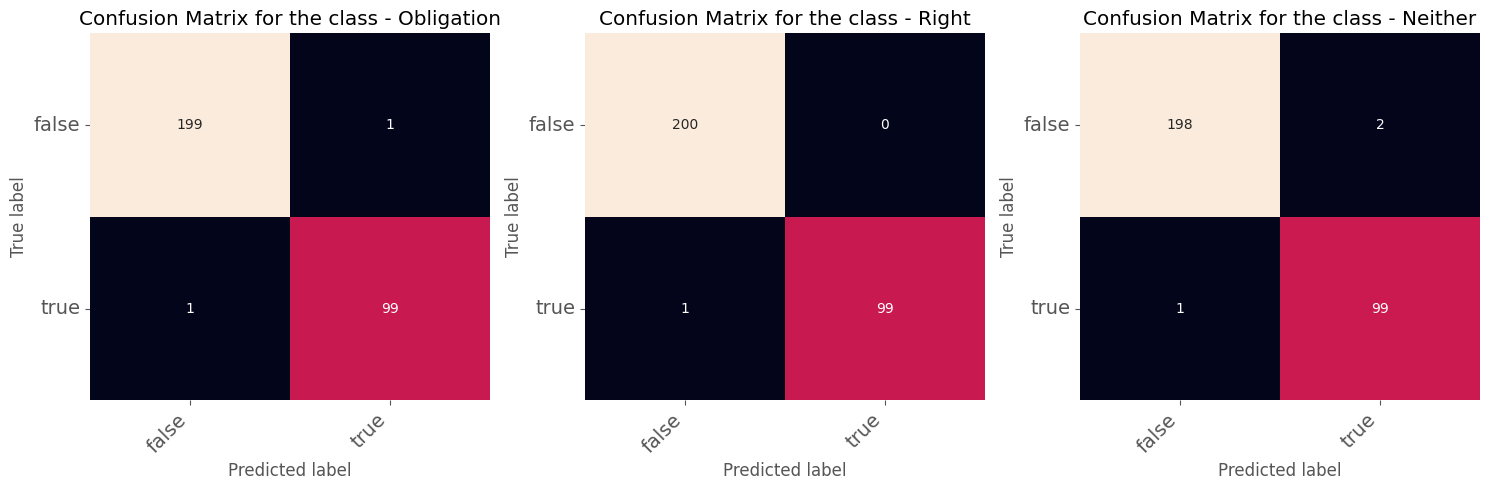

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
labels = ["".join("c" + str(i)) for i in range(0, 3)]
preds = model(train_dataset["text"]).tolist()
confusion_matrix = metrics.multilabel_confusion_matrix(train_dataset["label"], preds)

for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["false", "true"])
fig.tight_layout()
plt.show()

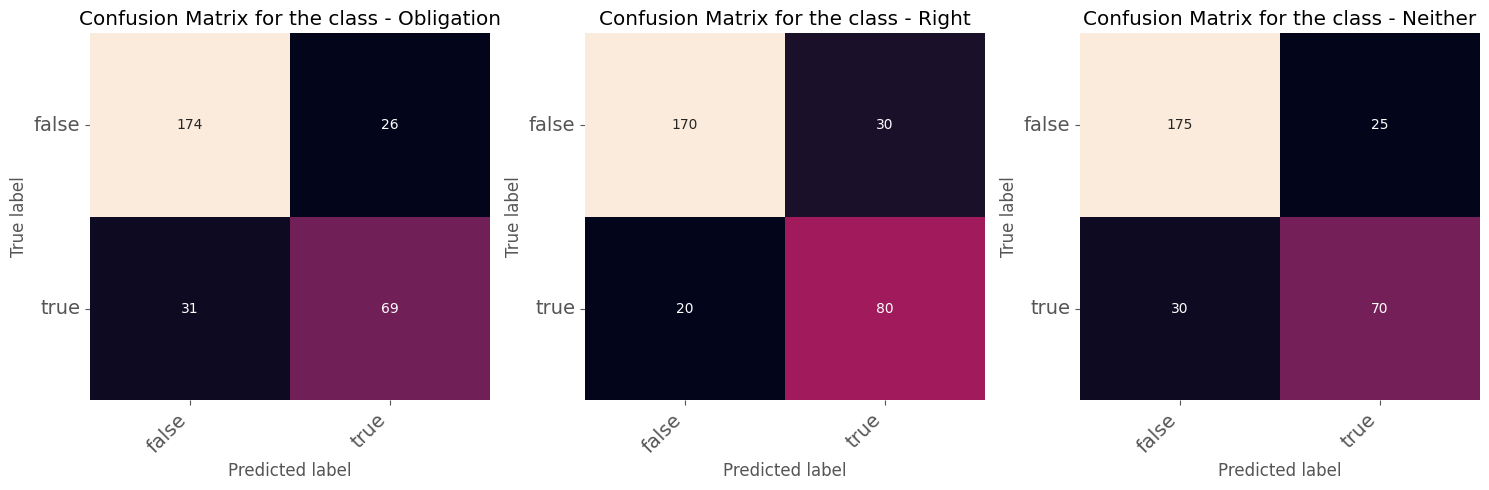

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
labels = ["".join("c" + str(i)) for i in range(0, 3)]
preds = model(eval_dataset["text"]).tolist()
confusion_matrix = metrics.multilabel_confusion_matrix(eval_dataset["label"], preds)

for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["false", "true"])
fig.tight_layout()
plt.show()

# Download model for test dataset inference
We download the trained model from the repository and observe the results obtained with the available test set. For this, the above metrics are evaluated and the embeddings are plotted. In addition, we will show how the model relates the words of one of the sentences depending on the context.

In [5]:
tokenizer = AutoTokenizer.from_pretrained(finetuning_model_id)
model_attention = AutoModel.from_pretrained(finetuning_model_id, output_attentions=True)

In [6]:
sentence = "If Verizon fails to meet the Network Latency Service Level in a calendar month for North American and Transatlantic, Customer may request a credit for that month"
inputs = tokenizer.encode(sentence, return_tensors='pt')
outputs = model_attention(inputs)
attention = outputs[-1]
tokens = tokenizer.convert_ids_to_tokens(inputs[0])

In [7]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [8]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>

Test evaluation

In [7]:
modelt = SetFitModel.from_pretrained(finetuning_model_id)
test_dataset = dataset["test"]
preds_test = modelt(test_dataset['text'])

In [8]:
preds_test

tensor([2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 1, 1, 1, 1])

In [9]:
print("Test results")
v_test = compute_metrics(preds_test, test_dataset['label'])
df_test = pd.DataFrame([v_test], columns=['Accuracy', 'F1-macro', 'Precision-macro', 'Recall-macro', 'Precision-micro', 'Recall-micro'])
df_test.head()

Test results


Accuracy  F1-macro  Precision-macro  Recall-macro  Precision-micro  \
0       0.8  0.727778         0.809524      0.782051              0.8   

   Recall-micro  
0           0.8

In [10]:
test_embeddings = modelt.model_body.encode(test_dataset["text"])

In [11]:
print_3d_embeddings_per_epoch(test_embeddings, test_dataset["label"], "Embeddings representation of the test set")

In [12]:
print_2d_embeddings_per_epoch(test_embeddings, test_dataset["label"], "Embeddings representation of the test set")

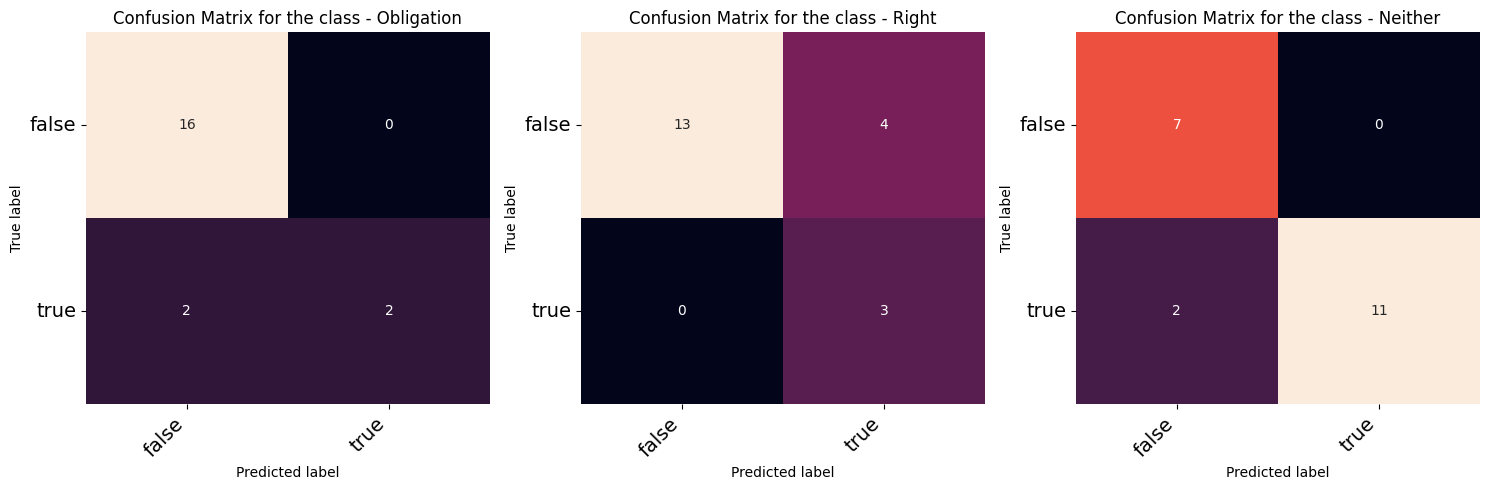

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
labels = ["".join("c" + str(i)) for i in range(0, 3)]
confusion_matrix = metrics.multilabel_confusion_matrix(test_dataset["label"], preds_test)

for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["false", "true"])
fig.tight_layout()
plt.show()